In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
raw_atlas_2019 = pd.read_csv('../data/processed/processed_atlas_2019.csv')
raw_atlas_2015 = pd.read_csv('../data/processed/processed_atlas_2015.csv')
raw_atlas_2010 = pd.read_csv('../data/processed/processed_atlas_2010.csv')
cols_to_drop = ["CensusTract", "Urban", "Unnamed: 0"]
processed_atlas_2019 = raw_atlas_2019.copy()
processed_atlas_2015 = raw_atlas_2015.copy()
processed_atlas_2010 = raw_atlas_2010.copy()
processed_atlas_2019 = processed_atlas_2019.drop(columns=cols_to_drop, errors='ignore')
processed_atlas_2015 = processed_atlas_2015.drop(columns=cols_to_drop, errors='ignore')
processed_atlas_2010 = processed_atlas_2010.drop(columns=cols_to_drop, errors='ignore')
pd.set_option('display.max_columns', None)
processed_atlas_2019.head()

,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lakids1share,laseniors1share,lahunv1share,lalowi1share,POP2010,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,0.113,0.999747,0.034381,0.042803,0.012796,0.000972,0.046897,0.9919,0.2633,0.1144,0.0079,0.2411,0.051027,0.237971,0.053347,0.003138,0.294456,0.005712
1,0.179,0.999699,0.060601,0.051161,0.012391,0.014411,0.071724,0.5811,0.1869,0.0583,0.0900,0.2783,0.057916,0.369585,0.071889,0.041014,0.482488,0.015948
2,0.150,0.999719,0.098685,0.075475,0.025418,0.016030,0.079080,0.4600,0.1234,0.0596,0.0000,0.1418,0.090038,0.387192,0.050993,0.029351,0.467536,0.021763
3,0.028,0.999731,0.069669,0.085690,0.052342,0.003400,0.045057,0.3109,0.0789,0.0539,0.0046,0.0783,0.117086,0.210214,0.022344,0.004788,0.237346,0.002868
4,0.152,0.999770,0.169412,0.266948,0.065196,0.037241,0.155862,0.2455,0.0664,0.0336,0.0135,0.0545,0.287442,0.208248,0.031488,0.021364,0.261100,0.037858


In [73]:
input_columns = [
    'PovertyRate', 'MedianFamilyIncome', 'TractLOWI', 'TractKids', 'TractSeniors',
    'TractHUNV', 'TractSNAP', 'lapop1share', 'laseniors1share', 'lahunv1share', 
    'POP2010', 'LOWIRatio', 'SNAPRatio', 'HUNVRatio', 'FoodInsecurityIndex', 'LOWIWeighted' 
]

In [76]:
class Autoencoder_Food_Desert_Model(nn.Module):
    def __init__(self, input_dim=16, latent_dim=8):
        super(Autoencoder_Food_Desert_Model, self).__init__()
        
        #Encode our dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 12),
            nn.ReLU(True),
            nn.Linear(12, latent_dim)
        )
        
        #Decoding these dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 16),
            nn.ReLU(True),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        encoding_result = self.encoder(input)
        decoding_output = self.decoder(encoding_result)
        return decoding_output


In [77]:
atlas_tensor_2019 = torch.tensor(processed_atlas_2019[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2015 = torch.tensor(processed_atlas_2015[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2010 = torch.tensor(processed_atlas_2010[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor_2019.shape

torch.Size([72531, 16])

In [78]:
train_size = int(0.9 * len(atlas_tensor_2019))
val_size = len(atlas_tensor_2019) - train_size
train_dataset_2019, val_dataset_2019 = random_split(atlas_tensor_2019, [train_size, val_size])
train_dataset_2015, val_dataset_2015 = random_split(atlas_tensor_2015, [train_size, val_size])
train_dataset_2010, val_dataset_2010 = random_split(atlas_tensor_2010, [train_size, val_size])

In [79]:
train_loader_2019 = DataLoader(train_dataset_2019, batch_size=64, shuffle=True)
val_loader_2019 = DataLoader(val_dataset_2019, batch_size=64, shuffle=False)
train_loader_2015 = DataLoader(train_dataset_2015, batch_size=64, shuffle=True)
val_loader_2015 = DataLoader(val_dataset_2015, batch_size=64, shuffle=False)
train_loader_2010 = DataLoader(train_dataset_2010, batch_size=64, shuffle=True)
val_loader_2010 = DataLoader(val_dataset_2010, batch_size=64, shuffle=False)

In [84]:
model_2019 = Autoencoder_Food_Desert_Model(input_dim=16, latent_dim=8).to(device)
model_2015 = Autoencoder_Food_Desert_Model(input_dim=16, latent_dim=8).to(device)
model_2010 = Autoencoder_Food_Desert_Model(input_dim=16, latent_dim=8).to(device)

In [85]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [86]:
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
                
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader.dataset):.6f} | Val Loss: {val_loss/len(val_loader.dataset):.6f}")

In [87]:
train_model(model_2019, nn.MSELoss(), optim.Adam(model_2019.parameters(), lr=0.001), 50,
           DataLoader(train_dataset_2019, batch_size=64, shuffle=True), DataLoader(val_dataset_2019, batch_size=64, shuffle=False))

Epoch 1/50 | Train Loss: 0.006056 | Val Loss: 0.002813
Epoch 2/50 | Train Loss: 0.002378 | Val Loss: 0.002125
Epoch 3/50 | Train Loss: 0.001822 | Val Loss: 0.002011
Epoch 4/50 | Train Loss: 0.001838 | Val Loss: 0.001303
Epoch 5/50 | Train Loss: 0.001641 | Val Loss: 0.000493
Epoch 6/50 | Train Loss: 0.002424 | Val Loss: 0.000389
Epoch 7/50 | Train Loss: 0.000469 | Val Loss: 0.000358
Epoch 8/50 | Train Loss: 0.000492 | Val Loss: 0.000353
Epoch 9/50 | Train Loss: 0.000422 | Val Loss: 0.000340
Epoch 10/50 | Train Loss: 0.000442 | Val Loss: 0.000355
Epoch 11/50 | Train Loss: 0.000408 | Val Loss: 0.000322
Epoch 12/50 | Train Loss: 0.000441 | Val Loss: 0.000327
Epoch 13/50 | Train Loss: 0.000401 | Val Loss: 0.000306
Epoch 14/50 | Train Loss: 0.000362 | Val Loss: 0.000311
Epoch 15/50 | Train Loss: 0.000336 | Val Loss: 0.000270
Epoch 16/50 | Train Loss: 0.000959 | Val Loss: 0.000273
Epoch 17/50 | Train Loss: 0.002528 | Val Loss: 0.000255
Epoch 18/50 | Train Loss: 0.000322 | Val Loss: 0.000235
E

In [88]:
train_model(model_2015, nn.MSELoss(), optim.Adam(model_2015.parameters(), lr=0.001), 50,
           DataLoader(train_dataset_2015, batch_size=64, shuffle=True), DataLoader(val_dataset_2015, batch_size=64, shuffle=False))

Epoch 1/50 | Train Loss: 0.007389 | Val Loss: 0.003694
Epoch 2/50 | Train Loss: 0.002183 | Val Loss: 0.001032
Epoch 3/50 | Train Loss: 0.000846 | Val Loss: 0.000618
Epoch 4/50 | Train Loss: 0.000585 | Val Loss: 0.000452
Epoch 5/50 | Train Loss: 0.000467 | Val Loss: 0.000421
Epoch 6/50 | Train Loss: 0.000414 | Val Loss: 0.000367
Epoch 7/50 | Train Loss: 0.000379 | Val Loss: 0.000362
Epoch 8/50 | Train Loss: 0.000408 | Val Loss: 0.000327
Epoch 9/50 | Train Loss: 0.000346 | Val Loss: 0.000304
Epoch 10/50 | Train Loss: 0.000364 | Val Loss: 0.000296
Epoch 11/50 | Train Loss: 0.000332 | Val Loss: 0.000303
Epoch 12/50 | Train Loss: 0.000669 | Val Loss: 0.000301
Epoch 13/50 | Train Loss: 0.000272 | Val Loss: 0.000251
Epoch 14/50 | Train Loss: 0.000311 | Val Loss: 0.000259
Epoch 15/50 | Train Loss: 0.000266 | Val Loss: 0.000225
Epoch 16/50 | Train Loss: 0.000250 | Val Loss: 0.000223
Epoch 17/50 | Train Loss: 0.000291 | Val Loss: 0.000233
Epoch 18/50 | Train Loss: 0.000248 | Val Loss: 0.000221
E

In [100]:
train_model(model_2010, nn.MSELoss(), optim.Adam(model_2010.parameters(), lr=0.001), 50,
           DataLoader(train_dataset_2010, batch_size=64, shuffle=True), DataLoader(val_dataset_2010, batch_size=64, shuffle=False))

Epoch 1/50 | Train Loss: 0.011278 | Val Loss: 0.006609
Epoch 2/50 | Train Loss: 0.003987 | Val Loss: 0.001320
Epoch 3/50 | Train Loss: 0.000800 | Val Loss: 0.000940
Epoch 4/50 | Train Loss: 0.000615 | Val Loss: 0.000909
Epoch 5/50 | Train Loss: 0.000755 | Val Loss: 0.000795
Epoch 6/50 | Train Loss: 0.000679 | Val Loss: 0.000776
Epoch 7/50 | Train Loss: 0.000562 | Val Loss: 0.000746
Epoch 8/50 | Train Loss: 0.000589 | Val Loss: 0.000771
Epoch 9/50 | Train Loss: 0.000471 | Val Loss: 0.000713
Epoch 10/50 | Train Loss: 0.000422 | Val Loss: 0.000659
Epoch 11/50 | Train Loss: 0.000464 | Val Loss: 0.000652
Epoch 12/50 | Train Loss: 0.000759 | Val Loss: 0.000652
Epoch 13/50 | Train Loss: 0.000356 | Val Loss: 0.000609
Epoch 14/50 | Train Loss: 0.000328 | Val Loss: 0.000612
Epoch 15/50 | Train Loss: 0.000633 | Val Loss: 0.000559
Epoch 16/50 | Train Loss: 0.000341 | Val Loss: 0.000583
Epoch 17/50 | Train Loss: 0.000410 | Val Loss: 0.000561
Epoch 18/50 | Train Loss: 0.000326 | Val Loss: 0.000540
E

In [101]:
model_2019.eval()
model_2015.eval()
model_2010.eval()
with torch.no_grad():
    latent_vectors_2019 = model_2019.encoder(atlas_tensor_2019.to(device)).cpu().numpy()
    latent_vectors_2015 = model_2015.encoder(atlas_tensor_2015.to(device)).cpu().numpy()
    latent_vectors_2010 = model_2010.encoder(atlas_tensor_2010.to(device)).cpu().numpy()
    print(latent_vectors_2019)
    print(latent_vectors_2015)
    print(latent_vectors_2010)

[[-1.5226898  -3.150257    0.8490593  ...  0.22358441 -3.2977397
  -0.6451024 ]
 [-0.33434418 -2.0707102   0.0428506  ...  0.2353273  -2.3649344
   0.0630376 ]
 [-0.04478911 -1.9633499  -0.45584697 ...  0.33360043 -2.1320727
   0.14719144]
 ...
 [ 0.9079032  -1.8695996  -1.505907   ...  0.54812914 -2.2016885
   0.87639654]
 [-0.74955094 -2.6294148   0.12471808 ...  0.36284932 -2.7711859
  -0.16881539]
 [ 0.08971845 -2.1295567  -0.7147031  ...  0.53413033 -2.3245747
   0.4298935 ]]
[[-6.3517749e-01  2.7981579e-01 -4.7500771e-01 ...  1.5726485e+00
  -8.4256899e-01 -1.9907995e+00]
 [ 1.5252979e-01  3.1537703e-01 -4.1585958e-01 ...  1.2619038e+00
  -7.2613478e-01 -1.5296795e+00]
 [ 5.2263126e-02  1.0570511e-05 -1.0707786e-01 ...  1.3966346e+00
  -6.6072285e-01 -1.4318221e+00]
 ...
 [ 4.9169922e-01  3.9430770e-01 -1.0060613e+00 ...  1.0027426e+00
  -9.5478767e-01 -1.3463475e+00]
 [-6.7559344e-01  3.1980455e-01 -6.5246767e-01 ...  1.3901119e+00
  -7.7725977e-01 -1.8818604e+00]
 [-8.8635981e-

In [102]:
kmeans_2019 = KMeans(n_clusters=7, random_state=42)
cluster_labels_2019 = kmeans_2019.fit_predict(latent_vectors_2019)

kmeans_2015 = KMeans(n_clusters=7, random_state=42)
cluster_labels_2015 = kmeans_2015.fit_predict(latent_vectors_2015)

kmeans_2010 = KMeans(n_clusters=7, random_state=42)
cluster_labels_2010 = kmeans_2010.fit_predict(latent_vectors_2010)

In [103]:
clustered_df_2019 = raw_atlas_2019.copy()
clustered_df_2019['Cluster'] = cluster_labels_2019
clustered_df_2015 = raw_atlas_2015.copy()
clustered_df_2015['Cluster'] = cluster_labels_2015
clustered_df_2010 = raw_atlas_2010.copy()
clustered_df_2010['Cluster'] = cluster_labels_2010

In [104]:
def plot_model(latent_vectors, model, cluster_labels):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
    plt.title(f'KMeans Clusters in Latent Space (PCA Projection year {model})')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()

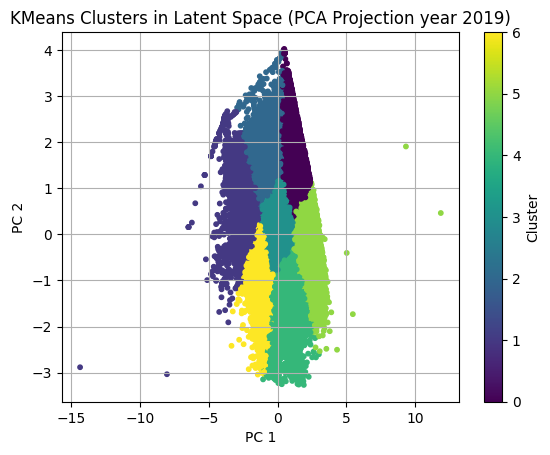

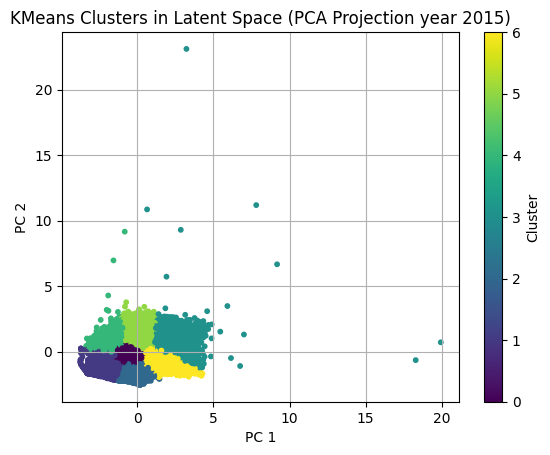

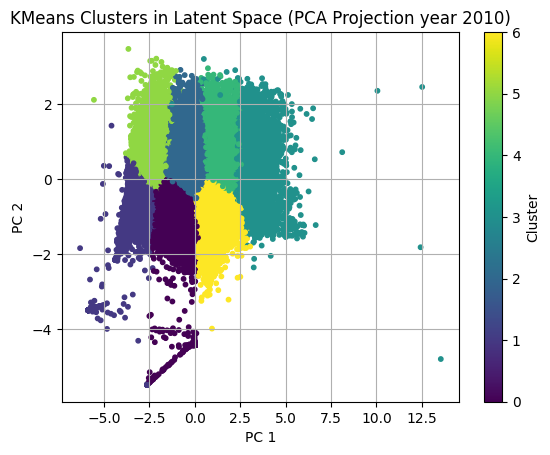

In [105]:
plot_model(latent_vectors_2019, '2019', cluster_labels_2019)
plot_model(latent_vectors_2015, '2015', cluster_labels_2015)
plot_model(latent_vectors_2010, '2010', cluster_labels_2010)

## 2019 clusters:

In [124]:
def cluster_save_df(clustered_df, year, cluster_map):
    cluster_means = clustered_df.groupby('Cluster').mean(numeric_only=True)[processed_atlas_2019.columns]
    print(cluster_means)
    clustered_df_cols = ['CensusTract', 'Cluster']
    save_clustered_df = clustered_df[clustered_df_cols]
    print(save_clustered_df['Cluster'].value_counts().sort_index())
    save_clustered_df.to_csv(f'../data/processed/clustered_atlas_labels_{year}.csv', index=False)
    print(f"Cluster labels saved at: ../data/processed/clustered_atlas_labels_{year}.csv")
    random_forest_labels = save_clustered_df.copy()

    random_forest_labels['Cluster'] = random_forest_labels['Cluster'].map(cluster_map)
    random_forest_labels.rename(columns={'Cluster': f'{year}_cluster'}, inplace=True)
    print(random_forest_labels[f'{year}_cluster'].value_counts().sort_index())
    random_forest_labels.to_csv(f'../data/processed/random_forest_labels_{year}.csv', index=False)
    print(f"RF labels saved at: ../data/processed/random_forest_labels_{year}.csv")

In [125]:
cluster_map_2019 = {
        4: 0,
        5: 0,
        6: 1,
        3: 1,
        0: 2,
        1: 2,
        2: 2
}
cluster_save_df(clustered_df_2019, 2019, cluster_map_2019)

         PovertyRate  MedianFamilyIncome  TractLOWI  TractKids  TractSeniors  \
Cluster                                                                        
0           0.076881            0.999775   0.062908   0.084683      0.035089   
1           0.062684            0.999773   0.043331   0.073148      0.030813   
2           0.041132            0.999827   0.031573   0.088375      0.031792   
3           0.112440            0.999749   0.090355   0.083966      0.034035   
4           0.291588            0.999694   0.172897   0.090286      0.026242   
5           0.230087            0.999705   0.157746   0.094575      0.031385   
6           0.162323            0.999717   0.117559   0.088190      0.035874   

         TractHUNV  TractSNAP  lapop1share  lakids1share  laseniors1share  \
Cluster                                                                     
0         0.012201   0.042067     0.114314      0.026387         0.016975   
1         0.005708   0.027709     0.953406      

In [126]:
cluster_map_2015 = {
        3: 0,
        5: 0,
        6: 1,
        4: 1,
        0: 2,
        2: 2,
        1: 2
}
cluster_save_df(clustered_df_2015, 2015, cluster_map_2015)

         PovertyRate  MedianFamilyIncome  TractLOWI  TractKids  TractSeniors  \
Cluster                                                                        
0           0.106887            0.999735   0.102733   0.104258      0.042373   
1           0.041575            0.999781   0.035575   0.089210      0.028117   
2           0.045456            0.999797   0.036925   0.086376      0.032305   
3           0.355104            0.999678   0.180062   0.084903      0.021616   
4           0.150400            0.999713   0.098696   0.073286      0.032696   
5           0.281523            0.999688   0.181233   0.098335      0.032984   
6           0.142026            0.999731   0.099775   0.073655      0.030591   

         TractHUNV  TractSNAP  lapop1share  lakids1share  laseniors1share  \
Cluster                                                                     
0         0.014207   0.078052     0.509570      0.118849         0.074942   
1         0.004675   0.020533     0.897270      

In [127]:
cluster_map_2010 = {
        3: 0,
        4: 0,
        2: 1,
        5: 1,
        6: 2,
        1: 2,
        0: 2
}
cluster_save_df(clustered_df_2010, 2010, cluster_map_2010)
#2 and 5

         PovertyRate  MedianFamilyIncome  TractLOWI  TractKids  TractSeniors  \
Cluster                                                                        
0           0.044010            0.975427   0.041997   0.097321      0.010818   
1           0.051197            0.965803   0.034965   0.069020      0.008758   
2           0.165210            0.999213   0.131211   0.102248      0.011213   
3           0.289970            0.996907   0.111546   0.054339      0.005908   
4           0.240567            0.998760   0.157391   0.095825      0.007636   
5           0.158896            0.998266   0.107942   0.084096      0.010477   
6           0.073823            0.997251   0.055780   0.075320      0.008770   

         TractHUNV  TractSNAP  lapop1share  lakids1share  laseniors1share  \
Cluster                                                                     
0         0.006996   0.018013     0.597155      0.600281         0.582798   
1         0.004382   0.015489     0.985139      

### Cluster definitions
Labeled as 0 - High risk of being a food desert

Labeled as 1 - Moderate/low risk of being a food desert

Labeled as 2 - Low/no risk of being a food desert

If you rerun this notebook, the cluster meanings will inevitably shuffle. As of now (what you'll find in the rf labels file), our clusters can be categorized with this description. 

### Why do we group into 3 sections for our RF model?
Sadly, tree models (Random Forest/XGBoost) do not categorize data well when there are many groups.

While our GUI will likely show the specific clusters (out of 7) in our classification mode, our tree models (in prediction mode) need less groups for the sake of meaningful categorization.

We can compromise on the specificity of clusters in order to output a meaningful prediction of whether a tract is likely to become a food desert, likely to be designated at a moderate risk, or likely to be completely safe from being a food desert.

### Additional color setting (so it doesn't have to be done client-side on our website)

In [3]:
complex_cluster_2019 = pd.read_csv('../data/processed/clustered_atlas_labels_2019.csv')
complex_cluster_2015 = pd.read_csv('../data/processed/clustered_atlas_labels_2015.csv')
complex_cluster_2010 = pd.read_csv('../data/processed/clustered_atlas_labels_2010.csv')

In [4]:
cluster_map_2019 = {
    4: '#bd2f42',
    5: '#c44927',
    6: '#c49027',
    3: '#c4c127',
    0: '#8dc427',
    1: '#73c916',
    2: '#38ad15'
}

cluster_map_2015 = {
    3: '#bd2f42',
    5: '#c44927',
    6: '#c49027',
    4: '#c4c127',
    0: '#8dc427',
    1: '#73c916',
    2: '#38ad15'
}

cluster_map_2010 = {
    3: '#bd2f42',
    4: '#c44927',
    2: '#c49027',
    5: '#c4c127',
    1: '#8dc427',
    6: '#73c916',
    0: '#38ad15'
}

In [6]:
color_map_2019 = complex_cluster_2019.copy()
color_map_2019['Color'] = color_map_2019['Cluster'].map(cluster_map_2019)
color_map_2015 = complex_cluster_2015.copy()
color_map_2015['Color'] = color_map_2015['Cluster'].map(cluster_map_2015)
color_map_2010 = complex_cluster_2010.copy()
color_map_2010['Color'] = color_map_2010['Cluster'].map(cluster_map_2010)

In [7]:
color_map_2019 = color_map_2019.drop(columns=['Cluster'])
color_map_2015 = color_map_2015.drop(columns=['Cluster'])
color_map_2010 = color_map_2010.drop(columns=['Cluster'])

In [8]:
color_map_2019.to_csv('../data/processed/color_settings/color_atlas_labels_2019.csv')
color_map_2015.to_csv('../data/processed/color_settings/color_atlas_labels_2015.csv')
color_map_2010.to_csv('../data/processed/color_settings/color_atlas_labels_2010.csv')